# Demo: Transfer learning

*Fraida Fund*

In practice, for most machine learning problems, you wouldn’t design or train a convolutional neural network from scratch - you would use an existing model that suits your needs (does well on ImageNet, size is right) and fine-tune it on your own data.

Note: for faster training, use Runtime \> Change Runtime Type to run this notebook on a GPU.

## Import dependencies

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)

Python version: 3.11.11
Tensorflow version: 2.18.0


## Import data

The “rock paper scissors” dataset is available directly from the `tensorflow_datasets` package. In the cells that follow, we’ll get the data, plot a few examples, and also prepare a preprocessing function (which we won’t apply yet).

In [2]:
import tensorflow_datasets as tfds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'rock_paper_scissors',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,  # ensures output is (image, label)
    with_info=True
)

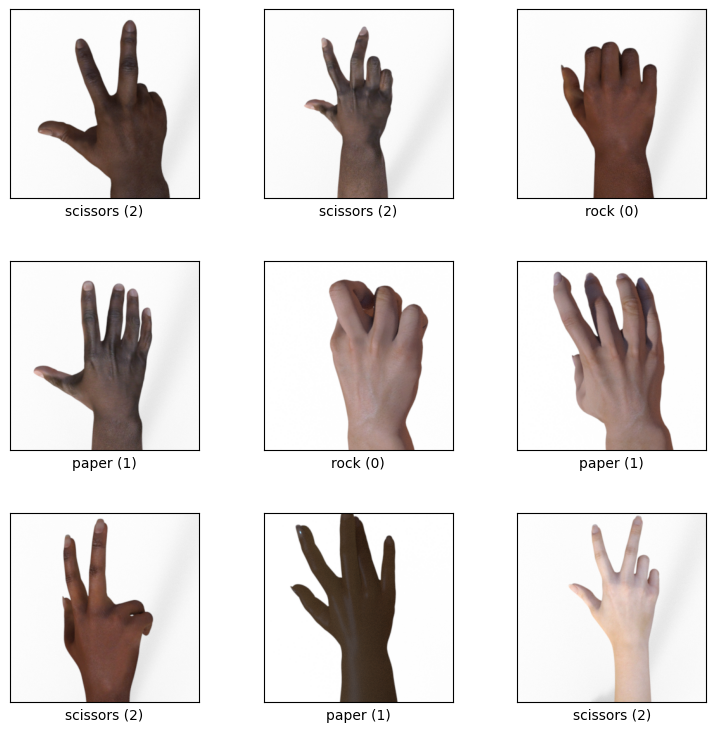

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
classes = np.array(['rock', 'paper', 'scissors'])

## Pre-process dataset

Each of the base models that comes in Keras has its own `preprocess_input` function. We’re going to use a [MobileNetV2](https://keras.io/api/applications/mobilenet/#mobilenetv2-function) model (which expects image data to have values in the -1 to 1 range), so we will use its specific preprocessing function.

In [6]:
INPUT_IMG_SIZE = 224
INPUT_IMG_SHAPE = (224, 224, 3)

In [7]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (INPUT_IMG_SIZE, INPUT_IMG_SIZE))
    # Preprocessing for MobileNetV2 - scales to whatever range MobileNetV2 expects
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

We won’t apply this preprocessing to our dataset yet, but we will get this function ready so that we can apply it to a test sample very soon.

## Upload custom test sample

This code expects a PNG image.

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving scissors.png to scissors.png
User uploaded file "scissors.png" with length 5229809 bytes


In [9]:
from PIL import Image

# Edit the filename here as needed
filename = 'scissors.png'

# pre-process image
image = Image.open(filename).convert('RGB')
image_resized = image.resize((INPUT_IMG_SIZE, INPUT_IMG_SIZE), Image.BICUBIC)
test_sample = np.array(image_resized)
test_sample = test_sample.reshape(1, INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3)

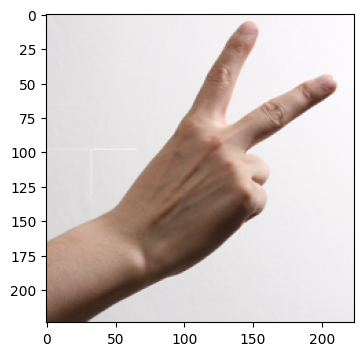

In [10]:
import seaborn as sns

plt.figure(figsize=(4,4));
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

## Classify with MobileNetV2

[Keras Applications](https://keras.io/api/applications/) are pre-trained models with saved weights, that you can download and use without any additional training.

Here is a table of the models available as Keras Applications.

In this table, the top-1 and top-5 accuracy refer to the model's performance on the ImageNet validation dataset, and depth is the depth of the network including activation layers, batch normalization layers, etc.

<table>
<thead>
<tr>
<th>Model</th>
<th align="right">Size</th>
<th align="right">Top-1 Accuracy</th>
<th align="right">Top-5 Accuracy</th>
<th align="right">Parameters</th>
<th align="right">Depth</th>
</tr>
</thead>
<tbody>
<tr>
<td>Xception</td>
<td align="right">88 MB</td>
<td align="right">0.790</td>
<td align="right">0.945</td>
<td align="right">22,910,480</td>
<td align="right">126</td>
</tr>
<tr>
<td>VGG16</td>
<td align="right">528 MB</td>
<td align="right">0.713</td>
<td align="right">0.901</td>
<td align="right">138,357,544</td>
<td align="right">23</td>
</tr>
<tr>
<td>VGG19</td>
<td align="right">549 MB</td>
<td align="right">0.713</td>
<td align="right">0.900</td>
<td align="right">143,667,240</td>
<td align="right">26</td>
</tr>
<tr>
<td>ResNet50</td>
<td align="right">98 MB</td>
<td align="right">0.749</td>
<td align="right">0.921</td>
<td align="right">25,636,712</td>
<td align="right">-</td>
</tr>
<tr>
<td>ResNet101</td>
<td align="right">171 MB</td>
<td align="right">0.764</td>
<td align="right">0.928</td>
<td align="right">44,707,176</td>
<td align="right">-</td>
</tr>
<tr>
<td>ResNet152</td>
<td align="right">232 MB</td>
<td align="right">0.766</td>
<td align="right">0.931</td>
<td align="right">60,419,944</td>
<td align="right">-</td>
</tr>
<tr>
<td>ResNet50V2</td>
<td align="right">98 MB</td>
<td align="right">0.760</td>
<td align="right">0.930</td>
<td align="right">25,613,800</td>
<td align="right">-</td>
</tr>
<tr>
<td>ResNet101V2</td>
<td align="right">171 MB</td>
<td align="right">0.772</td>
<td align="right">0.938</td>
<td align="right">44,675,560</td>
<td align="right">-</td>
</tr>
<tr>
<td>ResNet152V2</td>
<td align="right">232 MB</td>
<td align="right">0.780</td>
<td align="right">0.942</td>
<td align="right">60,380,648</td>
<td align="right">-</td>
</tr>
<tr>
<td>InceptionV3</td>
<td align="right">92 MB</td>
<td align="right">0.779</td>
<td align="right">0.937</td>
<td align="right">23,851,784</td>
<td align="right">159</td>
</tr>
<tr>
<td>InceptionResNetV2</td>
<td align="right">215 MB</td>
<td align="right">0.803</td>
<td align="right">0.953</td>
<td align="right">55,873,736</td>
<td align="right">572</td>
</tr>
<tr>
<td>MobileNet</td>
<td align="right">16 MB</td>
<td align="right">0.704</td>
<td align="right">0.895</td>
<td align="right">4,253,864</td>
<td align="right">88</td>
</tr>
<tr>
<td>MobileNetV2</td>
<td align="right">14 MB</td>
<td align="right">0.713</td>
<td align="right">0.901</td>
<td align="right">3,538,984</td>
<td align="right">88</td>
</tr>
<tr>
<td>DenseNet121</td>
<td align="right">33 MB</td>
<td align="right">0.750</td>
<td align="right">0.923</td>
<td align="right">8,062,504</td>
<td align="right">121</td>
</tr>
<tr>
<td>DenseNet169</td>
<td align="right">57 MB</td>
<td align="right">0.762</td>
<td align="right">0.932</td>
<td align="right">14,307,880</td>
<td align="right">169</td>
</tr>
<tr>
<td>DenseNet201</td>
<td align="right">80 MB</td>
<td align="right">0.773</td>
<td align="right">0.936</td>
<td align="right">20,242,984</td>
<td align="right">201</td>
</tr>
<tr>
<td>NASNetMobile</td>
<td align="right">23 MB</td>
<td align="right">0.744</td>
<td align="right">0.919</td>
<td align="right">5,326,716</td>
<td align="right">-</td>
</tr>
<tr>
<td>NASNetLarge</td>
<td align="right">343 MB</td>
<td align="right">0.825</td>
<td align="right">0.960</td>
<td align="right">88,949,818</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB0</td>
<td align="right">29 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">5,330,571</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB1</td>
<td align="right">31 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">7,856,239</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB2></td>
<td align="right">36 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">9,177,569</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB3</td>
<td align="right">48 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">12,320,535</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB4</td>
<td align="right">75 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">19,466,823</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB5</td>
<td align="right">118 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">30,562,527</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB6</td>
<td align="right">166 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">43,265,143</td>
<td align="right">-</td>
</tr>
<tr>
<td>EfficientNetB7</td>
<td align="right">256 MB</td>
<td align="right">-</td>
<td align="right">-</td>
<td align="right">66,658,687</td>
<td align="right">-</td>
</tr>
</tbody>
</table>

(A variety of other models is available from other sources - for example, the [Tensorflow Hub](https://tfhub.dev/).)

I'm going to use MobileNetV2, which is designed specifically to be small and fast (so it can run on mobile devices!)

MobileNets come in various sizes controlled by a multiplier for the depth (number of features), and trained for various sizes of input images. We will use the 224x224 input image size.

In [11]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE
)

In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 3,538,984 (13.50 MB)

 Trainable params: 3,504,872 (13.37 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [13]:
# preprocess test sample before using it
test_sample_pre, _ = preprocess_image(test_sample, label=2)
base_probs = base_model.predict(test_sample_pre)
base_probs.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(1, 1000)

In [14]:
url = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_classes = np.array(open(url).read().splitlines())[1:]
imagenet_classes.shape

(1000,)

Let’s see what the top 5 predicted classes are for my test image:

In [15]:
most_likely_classes = np.argsort(base_probs.squeeze())[-5:]

<ipython-input-16-bbf2ac483900>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p.set_xticklabels(p.get_xticklabels(), rotation=45);


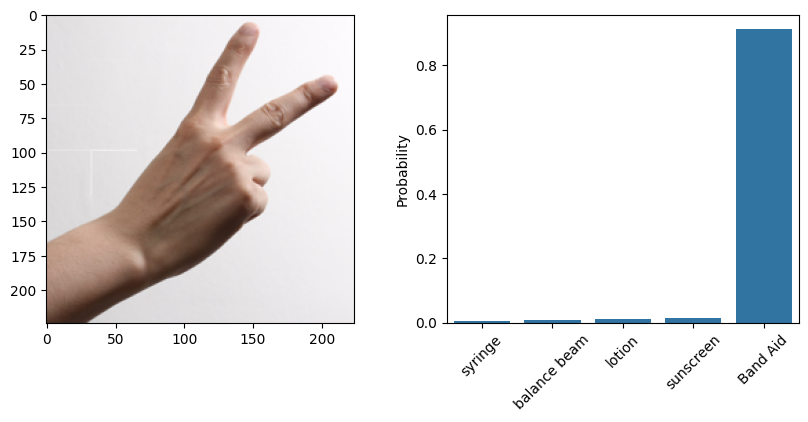

In [16]:
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(x=imagenet_classes[most_likely_classes],y=base_probs.squeeze()[most_likely_classes]);
plt.ylabel("Probability");
p.set_xticklabels(p.get_xticklabels(), rotation=45);

MobileNetV2 is trained on a specific task: classifying the images in the ImageNet dataset by selecting the most appropriate of 1000 class labels.

It is not trained for our specific task: classifying an image of a hand as rock, paper, or scissors.

## Background: fine-tuning a model

A typical convolutional neural network looks something like this:

<figure>
<img src="https://raw.githubusercontent.com/LongerVision/Resource/master/AI/Visualization/PlotNeuralNet/vgg16.png" alt="Image via PlotNeuralNet" />
<figcaption aria-hidden="true">Image via <a href="https://github.com/HarisIqbal88/PlotNeuralNet">PlotNeuralNet</a></figcaption>
</figure>

We have a sequence of convolutional layers followed by pooling layers. These layers are *feature extractors* that “learn” key features of our input images.

Then, we have one or more fully connected layers followed by a fully connected layer with a softmax activation function. This part of the network is for *classification*.

The key idea behind transfer learning is that the *feature extractor* part of the network can be re-used across different tasks and different domains.

This is especially useful when we don’t have a lot of task-specific data. We can get a pre-trained feature extractor trained on a lot of data from another task, then train the classifier on task-specific data.

The general process is:

-   Get a pre-trained model, without the classification layer.
-   Freeze the base model.
-   Add a classification layer.
-   Train the model (only the weights in your classification layer will be updated).
-   (Optional) Un-freeze some of the last layers in your base model.
-   (Optional) Train the model again, with a smaller learning rate.

## Train our own classification head

This time, we will get the MobileNetV2 model *without* the fully connected layer at the top of the network.

In [17]:
base_model = tf.keras.applications.MobileNetV2(
  input_shape=INPUT_IMG_SHAPE,
  include_top=False,
  pooling='avg'
)

In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

Then, we will *freeze* the model. We're not going to train the MobileNetV2 part of the model, we're just going to use it to extract features from the images.

In [19]:
base_model.trainable = False

We’l make a *new* model out of the “headless” already-fitted MobileNetV2, with a brand-new, totally untrained classification head on top:

In [20]:
model = tf.keras.models.Sequential()

model.add(base_model)
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(
    units=3,
    activation=tf.keras.activations.softmax
))

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

We’l compile the model:

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

Also, we’ll use data augmentation:

In [23]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.95, upper=1.05)
    image = tf.image.random_crop(
    image, size=(image.shape[0] - 2, image.shape[1] - 2, image.shape[2])
    )
    image = tf.image.resize(image, (INPUT_IMG_SIZE, INPUT_IMG_SIZE))
    return image, label

Here, we apply data augmentation and preprocessing to the training data; and just preprocessing to the test data.

In [24]:
BATCH_SIZE=64
ds_train = ds_train.map(preprocess_image)
ds_train = ds_train.map(augment_image)
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

ds_test  = ds_test.map(preprocess_image)
ds_test  = ds_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Now we can start training our model. Remember, we are *only* updating the weights in the classification head.

Also note that we are not doing early stopping or otherwise “using” the data passed as `validation_data`, so it’s OK to use the test data in this instance.

In [25]:
n_epochs = 20

hist = model.fit(
    ds_train,
    epochs = n_epochs,
    validation_data = ds_test
)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 35s 553ms/step - accuracy: 0.4051 - loss: 1.2596 - val_accuracy: 0.4140 - val_loss: 1.0573
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step - accuracy: 0.5699 - loss: 0.9008 - val_accuracy: 0.6237 - val_loss: 0.9055
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.7444 - loss: 0.6862 - val_accuracy: 0.6909 - val_loss: 0.8064
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.8277 - loss: 0.5539 - val_accuracy: 0.7258 - val_loss: 0.7297
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.8815 - loss: 0.4635 - val_accuracy: 0.7366 - val_loss: 0.6809
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.9143 - loss: 0.3793 - val_accuracy: 0.7634 - val_loss: 0.6282
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 0.9455 - loss: 0.3291 - val_accuracy: 0.7661 - val_loss: 0.6034
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.9491 - loss: 0.2824 - val_accuracy:

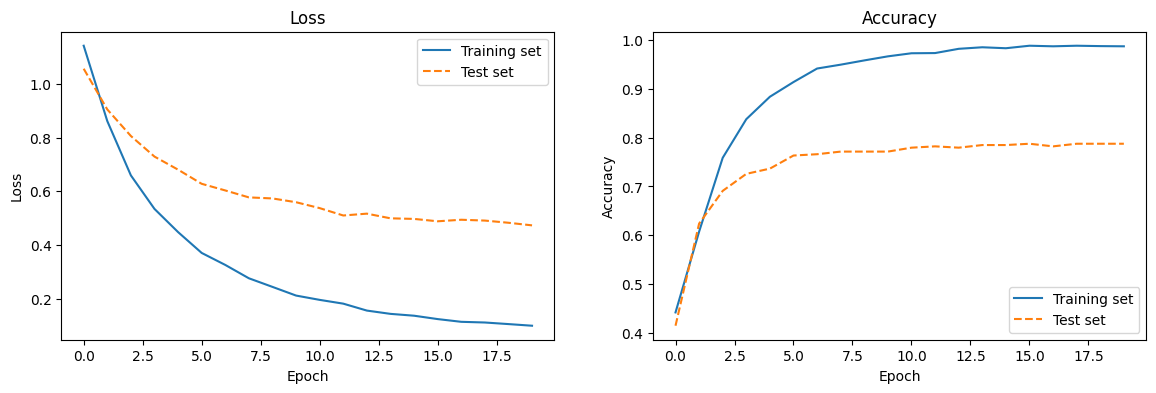

In [26]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='--')
plt.legend()

plt.show()

## Fine-tune model

We have fitted our own classification head, but there's one more step we can attempt to customize the model for our particular application.

We are going to “un-freeze” the later parts of the model, and train it for a few more epochs on our data, so that the high-level features are better suited for our specific classification task.

In [27]:
base_model.trainable = True

In [28]:
len(base_model.layers)

155

Note that we are *not* creating a new model. We're just going to continue training the model we already started training.

In [29]:
fine_tune_at = 149

# freeze first layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# use a smaller training rate for fine-tuning
opt = tf.keras.optimizers.Adam(learning_rate=1e-6)
model.compile(
    optimizer = opt,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │           3,843 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 723,843 (2.76 MB)

 Non-trainable params: 1,537,984 (5.87 MB)

In [30]:
n_epochs_fine = 20

hist_fine = model.fit(
    ds_train,
    epochs=n_epochs + n_epochs_fine,
    initial_epoch=n_epochs,
    validation_data = ds_test
)

Epoch 21/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 389ms/step - accuracy: 0.9721 - loss: 0.1148 - val_accuracy: 0.7876 - val_loss: 0.4549
Epoch 22/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.9754 - loss: 0.1010 - val_accuracy: 0.7876 - val_loss: 0.4449
Epoch 23/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 134ms/step - accuracy: 0.9807 - loss: 0.0887 - val_accuracy: 0.7930 - val_loss: 0.4338
Epoch 24/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9888 - loss: 0.0783 - val_accuracy: 0.7930 - val_loss: 0.4242
Epoch 25/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 8s 137ms/step - accuracy: 0.9892 - loss: 0.0688 - val_accuracy: 0.7957 - val_loss: 0.4193
Epoch 26/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.9905 - loss: 0.0695 - val_accuracy: 0.7984 - val_loss: 0.4149
Epoch 27/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9943 - loss: 0.0639 - val_accuracy: 0.8038 - val_loss: 0.4097
Epoch 28/40
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 0.9912 - loss: 0.0603 - val

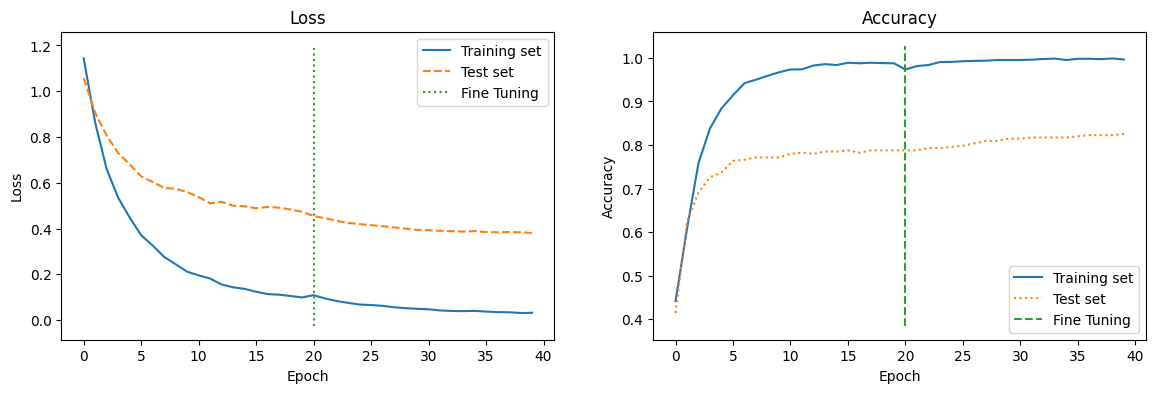

In [31]:
loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

accuracy = hist.history['accuracy'] + hist_fine.history['accuracy']
val_accuracy = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training set')
plt.plot(val_loss, label='Test set', linestyle='--')
plt.plot([n_epochs, n_epochs], plt.ylim(),label='Fine Tuning',linestyle='dotted')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(accuracy, label='Training set')
plt.plot(val_accuracy, label='Test set', linestyle='dotted')
plt.plot([n_epochs, n_epochs], plt.ylim(), label='Fine Tuning', linestyle='--')
plt.legend()

plt.show()

## Classify custom test sample

In [32]:
test_probs = model.predict(test_sample_pre)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


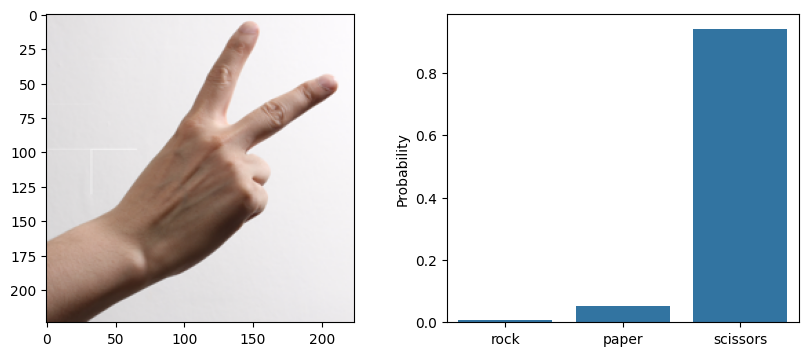

In [33]:
plt.figure(figsize=(10,4));

plt.subplot(1,2,1)
plt.imshow(test_sample.reshape(INPUT_IMG_SIZE, INPUT_IMG_SIZE, 3));

plt.subplot(1,2,2)
p = sns.barplot(x=classes,y=test_probs.squeeze());
plt.ylabel("Probability");

## Some comments

In practice, for most machine learning problems, you wouldn’t design or train a convolutional neural network from scratch - you would use an existing model that suits your needs (does well on ImageNet, size is right) and fine-tune it on your own data.

Transfer learning isn’t only for image classification.

There are many problems that can be solved by taking a VERY LARGE task-generic “feature detection” model trained on a LOT of data, and fine-tuning it on a small custom dataset.

For example, consider [AI Dungeon](https://play.aidungeon.io/), a game in the style of classic text-based adventure games.

It was trained by fine-tuning a version of GPT-2. GPT-2 is a language model with 1.5 billion parameters, trained on a dataset of 8 million web pages, with the objective of predicting the next word in a sequence.

The creator of AI Dungeon fine-tuned GTP-2 using story-games scraped from [ChooseYourStory.com](https://chooseyourstory.com/Stories/).

With so much data, the model doesn’t only learn about language and language features - it learns about the world described by all that text! Since the game is based on a fine-tuned version of that model, it also knows a lot about the world.